In [2]:
from google.cloud import storage
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
from io import StringIO
import json
import pickle
import six
import charset_normalizer
from wordcloud import WordCloud 

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

# init

In [5]:
client =  storage.Client().from_service_account_json("./heidless-jupyter-0-60b786da1dcf.json")

BUCKET_NAME = 'heidless-jupyter-bucket-0'

bucket = client.get_bucket(BUCKET_NAME)

DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

# load data

In [7]:
AllCSV = []
my_prefix = 'csv/'
blobs = client.list_blobs(bucket_or_name=bucket, prefix='csv/')
for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
#        file_name = blob.name.replace(my_prefix, "")
        file_name = blob.name
        AllCSV.append(file_name)
AllCSV

['csv/CAvideos.csv',
 'csv/DEvideos.csv',
 'csv/FRvideos.csv',
 'csv/GBvideos.csv',
 'csv/INvideos.csv',
 'csv/JPvideos.csv',
 'csv/KRvideos.csv',
 'csv/MXvideos.csv',
 'csv/RUvideos.csv',
 'csv/USvideos.csv']

## create dataframes

In [8]:
all_dataframes = []
#file_name = f'json/CA_category_id.json'

for csv in AllCSV:
    blob = bucket.get_blob(csv)
    if blob is not None and blob.exists(client):
        bt = blob.download_as_string()
        s = str(bt, 'ISO-8859-1')
        s = StringIO(s)
        df = pd.read_csv(s, encoding='ISO-8859-1')
        df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
        all_dataframes.append(df)
        print(csv)
    
all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets


csv/CAvideos.csv
csv/DEvideos.csv
csv/FRvideos.csv
csv/GBvideos.csv
csv/INvideos.csv
csv/JPvideos.csv
csv/KRvideos.csv
csv/MXvideos.csv
csv/RUvideos.csv
csv/USvideos.csv


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. BeyoncÃ© ...,cs
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,cs
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO â¶ \n\nSUBSCRIBE âº ...,cs
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,cs
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,ð§: https://ad.gt/yt-perfect\nð°: https://...,cs


## clean columns
- convert to 'str'
    - video_id
    - trending_date
- create 'date' columns
- format year to '2010' format
- trending_date: replace with reformated date components
    - delete date work files
- identify and set 'categorical' data type
- 'publish_time' : set date format

In [9]:
for df in all_dataframes:
    # video_id 
    df['video_id'] = df['video_id'].astype('str') 

    # trending date
    df['trending_date'] = df['trending_date'].astype('str') 
    date_pieces = (df['trending_date']
                   .str.split('.')
                  )
    df['Year'] = date_pieces.str[0].astype(int)
    df['Day'] = date_pieces.str[1].astype(int)
    df['Month'] = date_pieces.str[2].astype(int)
    
    updatedyear = []
    for i in range(len(df)) : 
        y = df.loc[i, "Year"]
        newy = y+2000
        updatedyear.append(newy)
    for i in range(len(df)):
        newy = updatedyear[i]
        tr = df.loc[i, "Year"]
        df['Year'].replace(to_replace = tr, value = newy, inplace=True)
        
    del df['trending_date']
    df['trending_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format = "%Y-%m-%d")
    del df['Year']
    del df['Day']
    del df['Month']
    
    #title
    df['title'] = df['title'].astype('str')
    #channel_title
    df['channel_title'] = df['channel_title'].astype('str')
    #category_id
    df['category_id'] = df['category_id'].astype(str) 
    
    #tags
    df['tags'] = df['tags'].astype('str')
    
    #thumbnail_link
    df['thumbnail_link'] = df['thumbnail_link'].astype('str') 
    
    #description
    df['description'] = df['description'].astype('str')
    
    # Changing comments_disabled, ratings_disabled, video_error_or_removed from bool to categorical
    df['comments_disabled'] = df['comments_disabled'].astype('category') 
    df['ratings_disabled'] = df['ratings_disabled'].astype('category') 
    df['video_error_or_removed'] = df['video_error_or_removed'].astype('category')
    
    # publish_time 
    df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')
    

- create 'publish_date' column 
    - strip only 'date' value from publish_time
    - set 'publish_time' to to only contain 'time' values 

In [10]:
for df in all_dataframes:
    df.insert(4, 'publish_date', df['publish_time'].dt.date) # loc, column name, values for column to be inserted
    df['publish_time'] = df['publish_time'].dt.time
# Changing data type for 'publish_date' from object to 'datetime64[ns]'
for df in all_dataframes:
     df['publish_date'] = pd.to_datetime(df['publish_date'], format = "%Y-%m-%d")

In [11]:
all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets

,video_id,title,channel_title,category_id,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,trending_date
0,n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. BeyoncÃ©,EminemVEVO,10,2017-11-10,17:00:03,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. BeyoncÃ© ...,cs,2017-11-14
1,0dBIkQ4Mz1M,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13,17:00:00,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...,cs,2017-11-14
2,5qpjK5DgCt4,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12,19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO â¶ \n\nSUBSCRIBE âº ...,cs,2017-11-14
3,d380meD0W0M,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12,18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,cs,2017-11-14
4,2Vv-BfVoq4g,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09,11:04:14,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,ð§: https://ad.gt/yt-perfect\nð°: https://...,cs,2017-11-14


In [12]:
# We can use any index from 0 to 9 inclusive (for each of the 10 dataframes
all_dataframes[1].dtypes

video_id                          object
title                             object
channel_title                     object
category_id                       object
publish_date              datetime64[ns]
publish_time                      object
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled               category
ratings_disabled                category
video_error_or_removed          category
description                       object
country                           object
trending_date             datetime64[ns]
dtype: object

### choose index

In [13]:
for df in all_dataframes:
    df.set_index('video_id', inplace=True)

## handle missing values
- using 'heatmap'
    - absences will show as 'orangle' square

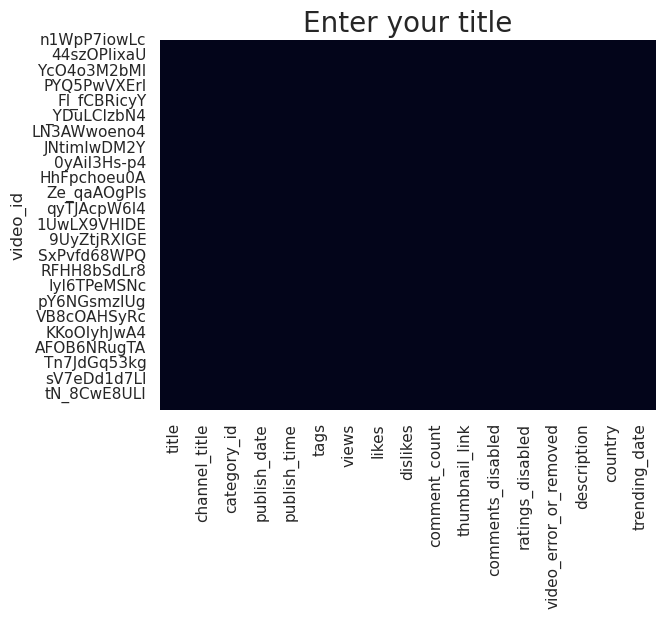

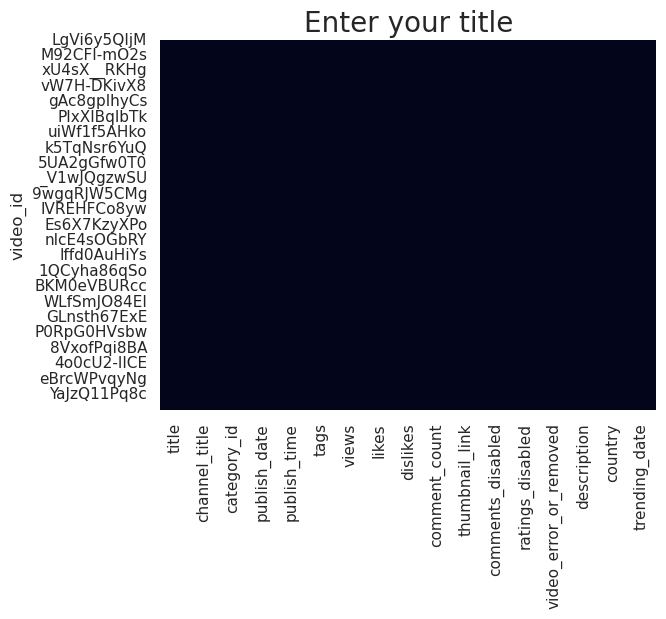

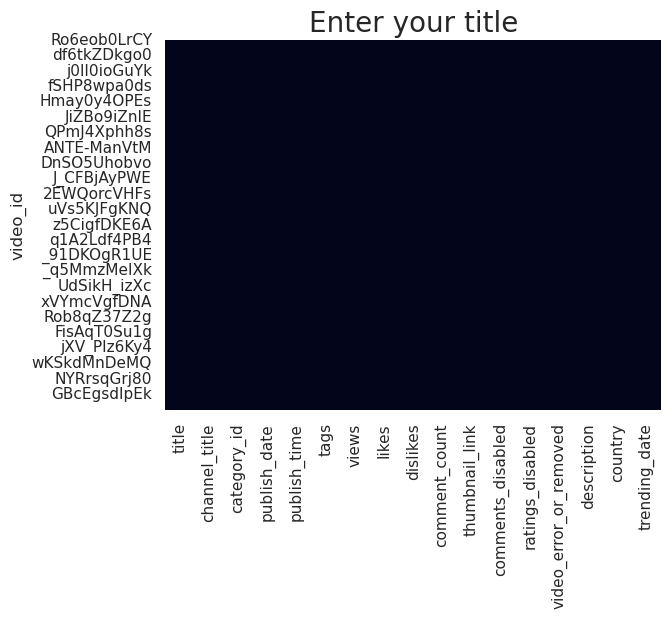

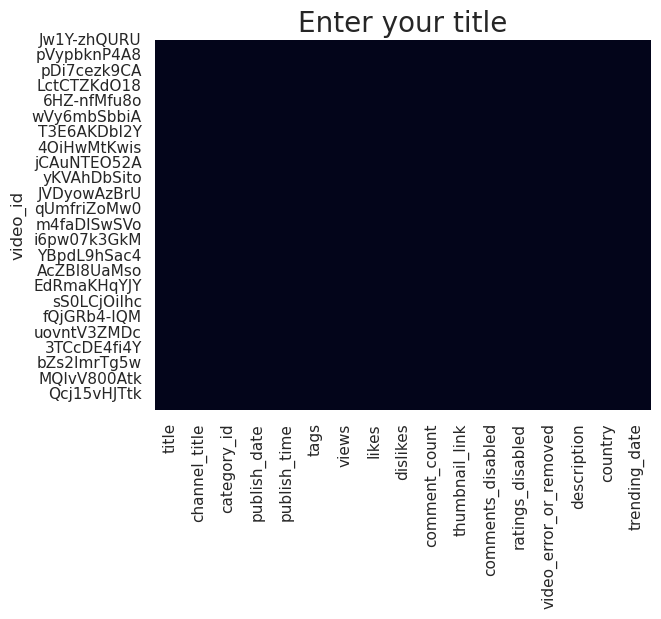

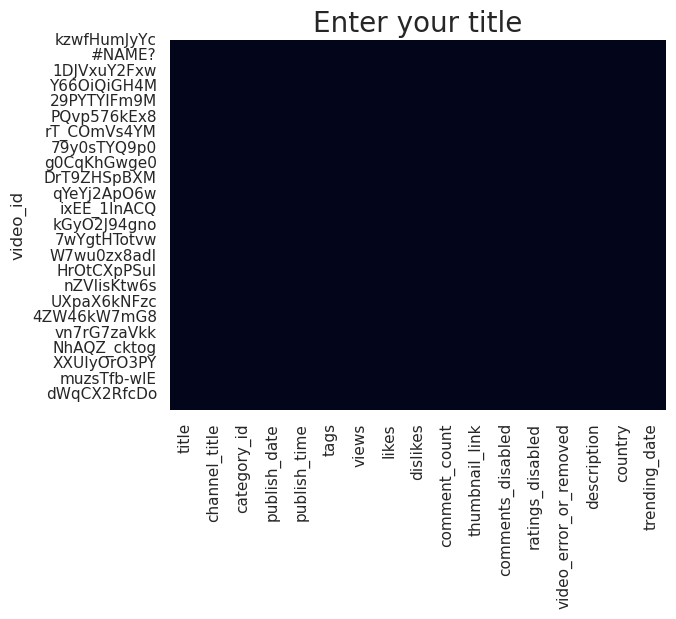

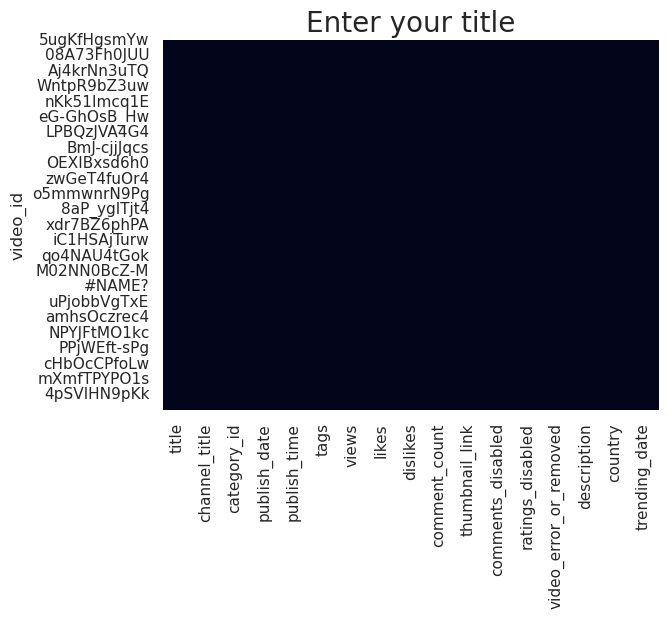

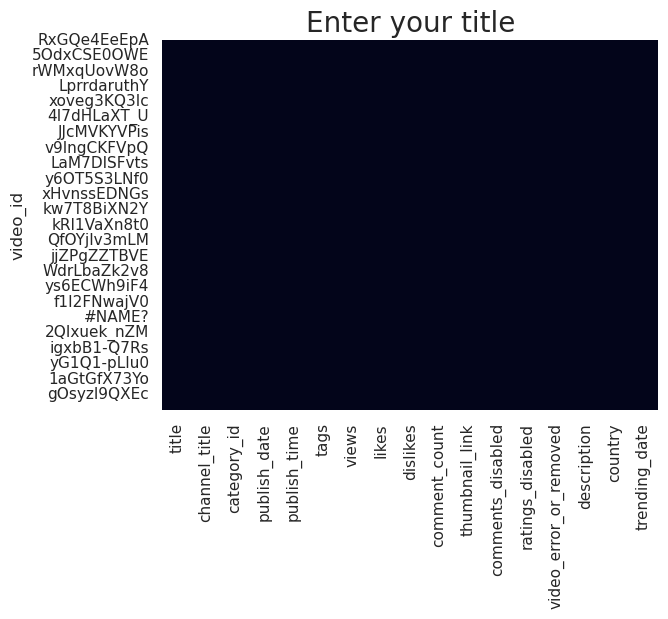

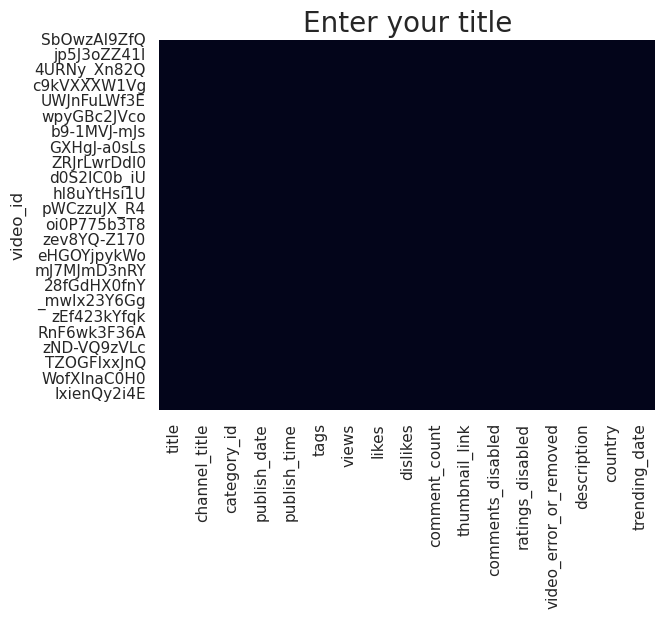

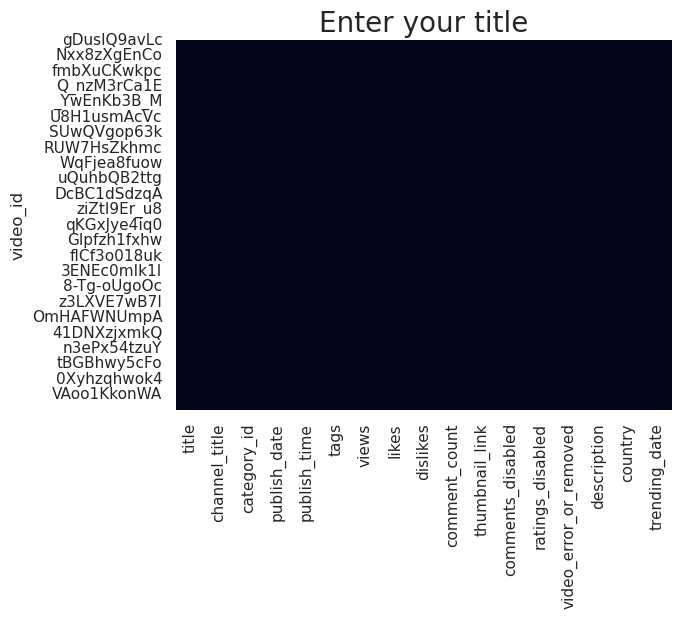

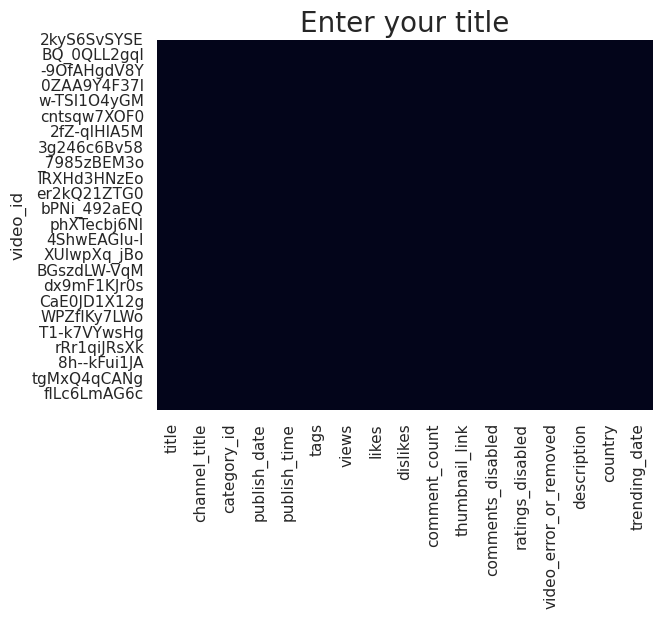

<Figure size 640x480 with 0 Axes>

In [14]:
for df in all_dataframes:
    sns.heatmap(df.isnull(), cbar=False)
    plt.title("Enter your title", fontsize =20)
    plt.figure()

# EDA prep

## consolidate dataframes

In [89]:
combined_df = pd.concat(all_dataframes)


In [90]:
# Making copy of original dataframe
backup_df = combined_df.reset_index().sort_values('trending_date', ascending=False).set_index('video_id')

### sort as appropriate
in this case latest 'trending_date' will be at top

In [91]:
# Sorting according to latest trending date while removing duplicates
combined_df = combined_df.reset_index().sort_values('trending_date', ascending=False).drop_duplicates('video_id',keep='first').set_index('video_id')

In [92]:
# Doing the same above operation for each of the individual dataframes in the list we created earlier
for df in all_dataframes:
    df = df.reset_index().sort_values('trending_date', ascending=False).set_index('video_id')

In [93]:
# Printing results
combined_df[['publish_date','publish_time','trending_date', 'country']].head()

,publish_date,publish_time,trending_date,country
video_id,,,,
ooyjaVdt-jA,2018-05-17,17:09:38,2018-06-14,cs
NXwn1iUbbJU,2018-06-13,20:13:30,2018-06-14,cs
AN2KspjYRLc,2018-06-12,15:07:36,2018-06-14,cs
WGKOBMZAwuM,2018-06-13,07:00:05,2018-06-14,cs
zauQhWWpa0s,2018-06-13,23:34:13,2018-06-14,cs


### Inserting Category Column
One of our final steps for the data cleaning of the data sets was checking the JSON files that
were available with the data sets. We needed to see whether or not these files contained any useful data. 
As there were multiple files, we decided to read two files at random, in order to check whether they contained the same
data or were they all containing different data.

json file pulled from file sytem

expore pulling frpm 'cloud storage'

In [94]:
file_name = f'json/JP_category_id.json'
blob = bucket.get_blob(file_name)
if blob is not None and blob.exists(client):
    data = blob.download_as_string()
    data1 = data.decode("ISO-8859-1")
    print(data1)

{
 "kind": "youtube#videoCategoryListResponse",
 "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/1v2mrzYSYG6onNLt2qTj13hkQZk\"",
 "items": [
  {
   "kind": "youtube#videoCategory",
   "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/Xy1mB4_yLrHy_BmKmPBggty2mZQ\"",
   "id": "1",
   "snippet": {
    "channelId": "UCBR8-60-B28hp2BmDPdntcQ",
    "title": "Film & Animation",
    "assignable": true
   }
  },
  {
   "kind": "youtube#videoCategory",
   "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/UZ1oLIIz2dxIhO45ZTFR3a3NyTA\"",
   "id": "2",
   "snippet": {
    "channelId": "UCBR8-60-B28hp2BmDPdntcQ",
    "title": "Autos & Vehicles",
    "assignable": true
   }
  },
  {
   "kind": "youtube#videoCategory",
   "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/nqRIq97-xe5XRZTxbknKFVe5Lmg\"",
   "id": "10",
   "snippet": {
    "channelId": "UCBR8-60-B28hp2BmDPdntcQ",
    "title": "Music",
    "assignable": true
   }
  },
  {
   "kind": "youtube#videoCategory",
   "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/HwXKamM1Q20q9BN-oBJavSGkfDI\"",

#### insert 'category' column & set based on json definition

In [95]:
category_id = {}
with open('GB_category_id.json', 'r') as f:
    d = json.load(f)
    for category in d['items']:
        category_id[category['id']] = category['snippet']['title']
combined_df.insert(2, 'category', combined_df['category_id'].map(category_id))
backup_df.insert(2, 'category', backup_df['category_id'].map(category_id))
for df in all_dataframes:
    df.insert(2, 'category', df['category_id'].map(category_id))
# Printing cleaned combined dataframe
combined_df.head(3)

,title,channel_title,category,category_id,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,trending_date
video_id,,,,,,,,,,,,,,,,,,
ooyjaVdt-jA,Official Call of DutyÂ®: Black Ops 4 âÂ Mult...,Call of Duty,Gaming,20,2018-05-17,17:09:38,"call of duty|""cod""|""activision""|""Black Ops 4""",10306119,357079,212976,144795,https://i.ytimg.com/vi/ooyjaVdt-jA/default.jpg,False,False,False,Call of Duty: Black Ops 4 Multiplayer raises t...,cs,2018-06-14
NXwn1iUbbJU,SÃ©rie ADJA - Episode 28,Marodi TV SÃ©nÃ©gal,Entertainment,24,2018-06-13,20:13:30,"senegal|""video""|""divertissement""|""humour""|""you...",213980,3940,188,801,https://i.ytimg.com/vi/NXwn1iUbbJU/default.jpg,False,False,False,Retrouvez - nous sur http://www.marodi.tv ou t...,cs,2018-06-14
AN2KspjYRLc,UN YOUTUBER DANS L'EMISSION LA PLUS GÃNANTE D...,Chelxie,Comedy,23,2018-06-12,15:07:36,"youtuber|""skyyart""|""les 12 coeurs""|""emission g...",176036,3673,1625,456,https://i.ytimg.com/vi/AN2KspjYRLc/default.jpg,False,False,False,un youtuber dans une emission gÃ©nante france ...,cs,2018-06-14


In [96]:
combined_df['category'].unique()

array(['Gaming', 'Entertainment', 'Comedy', 'Sports', 'Music',
       'Howto & Style', 'Film & Animation', 'People & Blogs', 'Education',
       'News & Politics', 'Pets & Animals', nan, 'Shows',
       'Travel & Events', 'Autos & Vehicles', 'Science & Technology',
       'Movies', 'Trailers'], dtype=object)

# EDA

<Axes: xlabel='ratio', ylabel='category'>

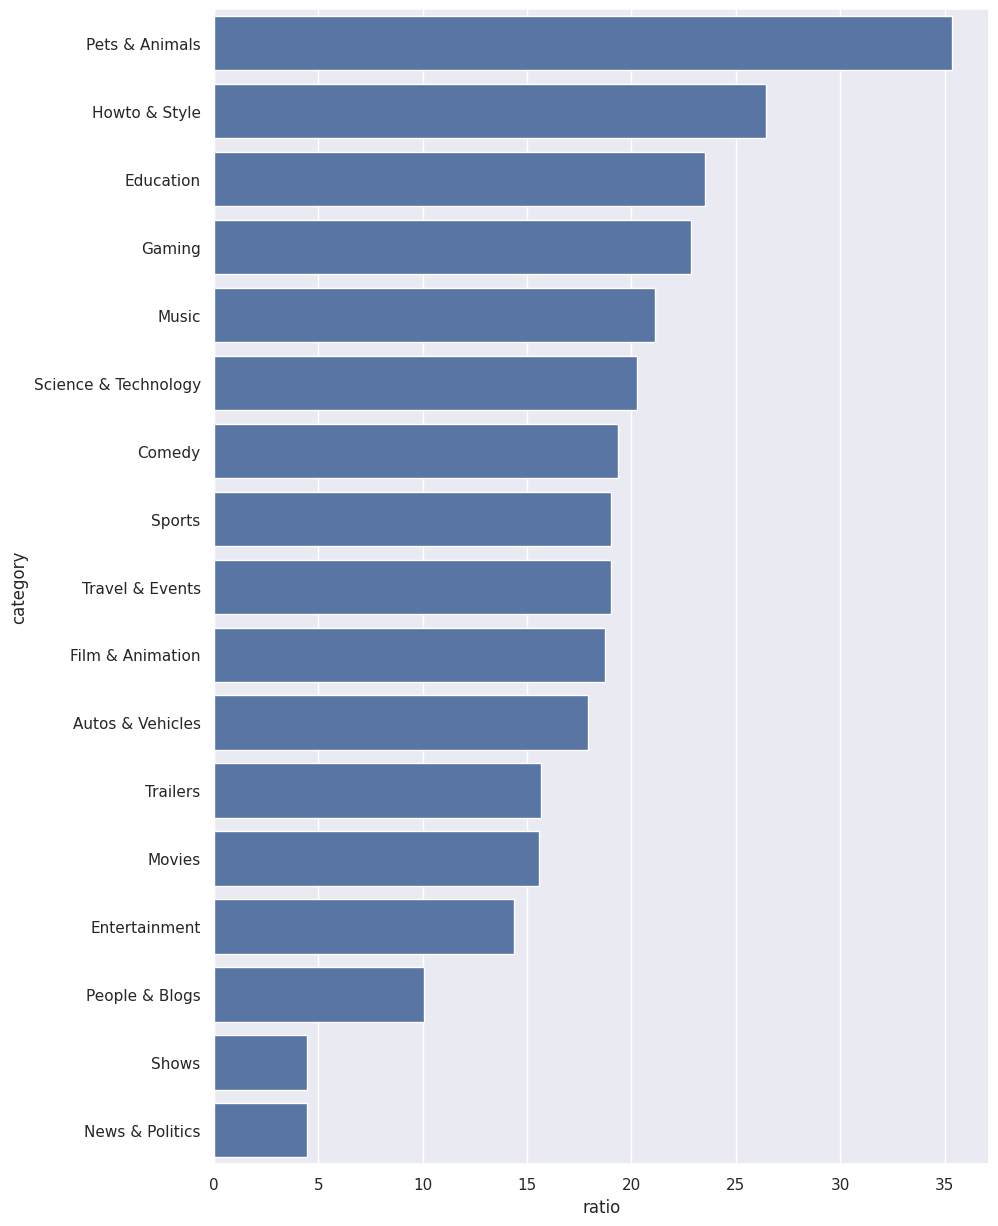

In [97]:
# calculating total likes for each category
likesdf = combined_df.groupby('category')['likes'].agg('sum')

# calculating total dislikes for each category
dislikesdf = combined_df.groupby('category')['dislikes'].agg('sum')

# calculating ratios of likes to dislikes
ratiodf = likesdf/dislikesdf 

# most liked category to appear on top
ratiodf = ratiodf.sort_values(ascending=False).reset_index()

# plotting bar chart
ratiodf.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=ratiodf,
            label="Likes-Dislikes Ratio", color="b")

#### Observations:

We see that videos belonging to the pets and animals categories have the highest ratio of likes to dislikes 
videos among the trending categories whereas new and politics videos have the least. 
From this we can infer that people are less divided on the content of videos based on entertainment than compared to 
topics such as News, whose content can lead to a division of opinions among the user.

#### Users like videos from which category more?
Next, we moved on to observe which categories were more preferred by the users, based on the likes on the videos in each category.
Three of the outputs were randomly selected from the ten plotted graphs and results are as follows:

allcsv: ['csv/CAvideos.csv', 'csv/DEvideos.csv', 'csv/FRvideos.csv', 'csv/GBvideos.csv', 'csv/INvideos.csv', 'csv/JPvideos.csv', 'csv/KRvideos.csv', 'csv/MXvideos.csv', 'csv/RUvideos.csv', 'csv/USvideos.csv']


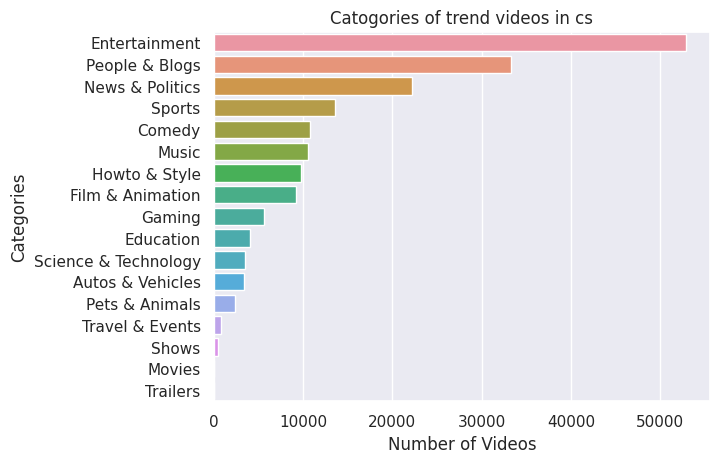

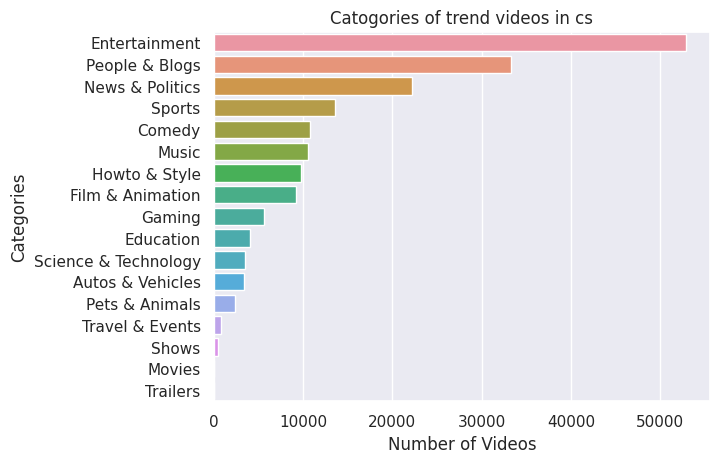

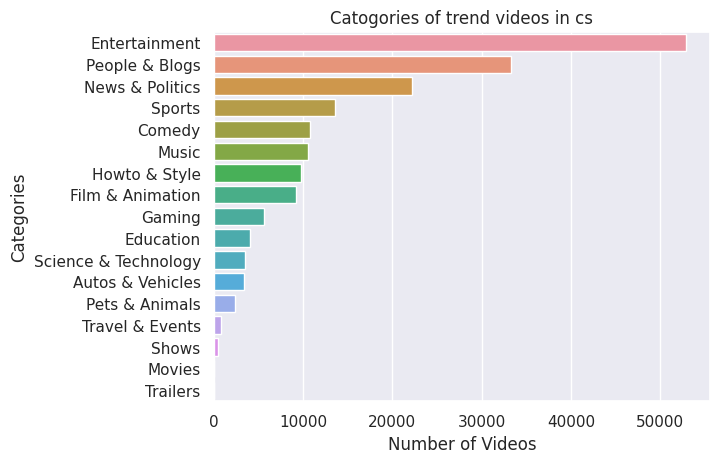

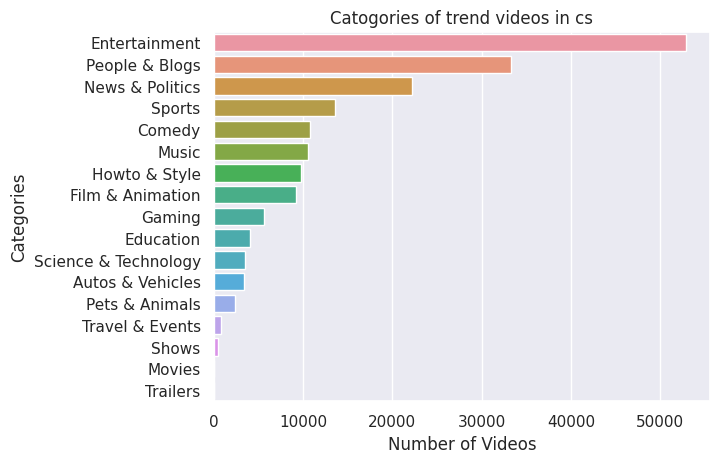

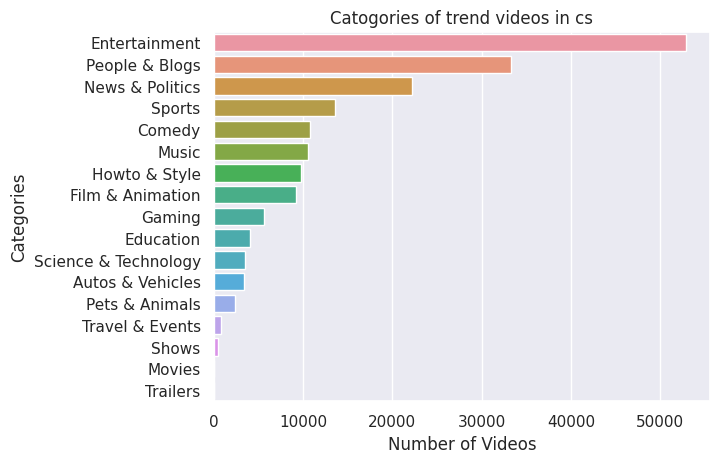

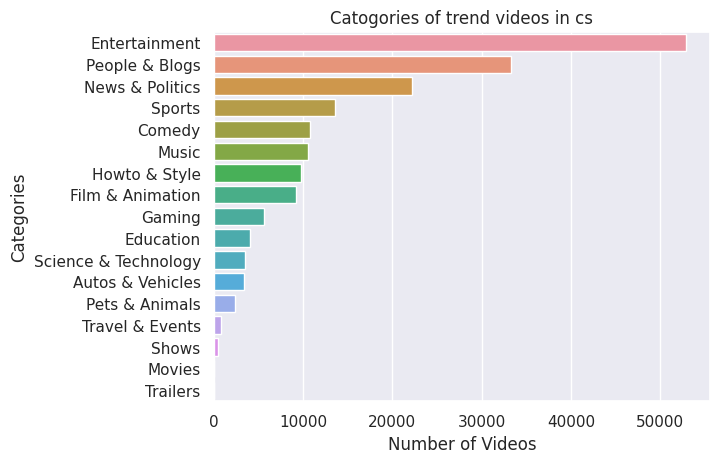

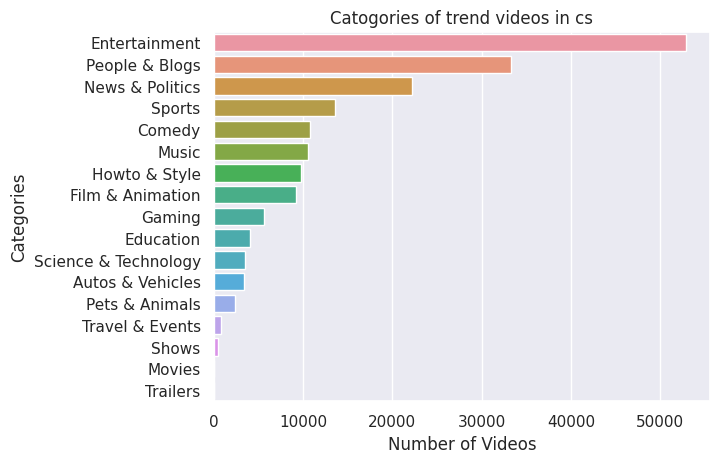

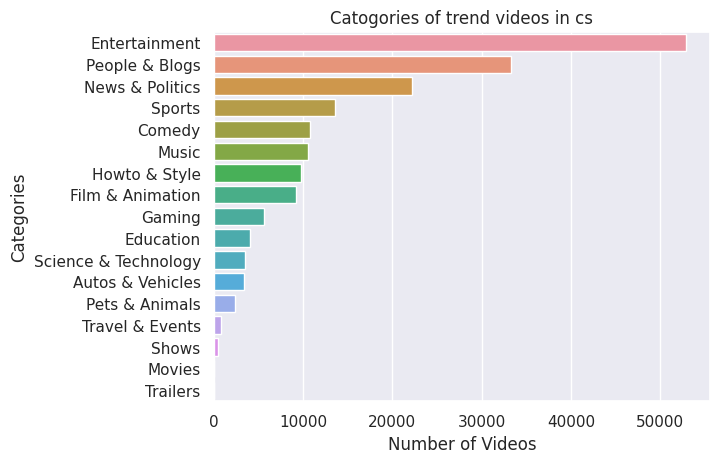

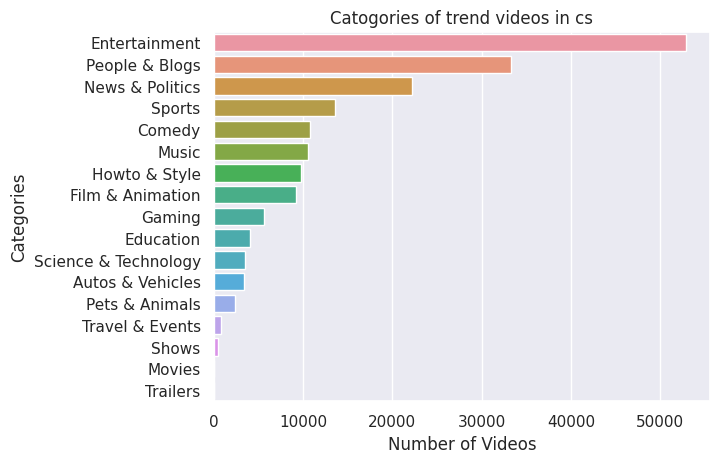

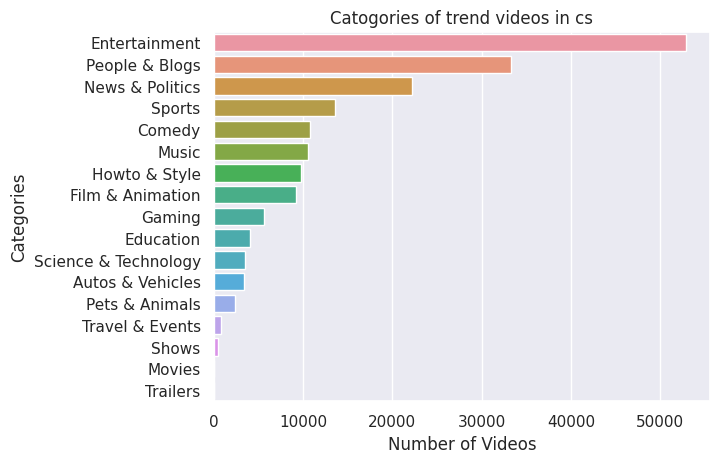

<Figure size 640x480 with 0 Axes>

In [98]:
# Getting names of all countries
countries = []
#allcsv = [i for i in glob.glob('*.{}'.format('csv'))]

allcsv = []
my_prefix = 'csv/'
blobs = client.list_blobs(bucket_or_name=bucket, prefix='csv/')
for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name
        allcsv.append(file_name)
        
print(f'allcsv: {allcsv}')

for csv in allcsv:
    c = csv[0:2]
    countries.append(c)
for country in countries:
    if country == 'US':
        tempdf = combined_df[combined_df['country']==country]['category'].value_counts().reset_index()
        ax = sns.barplot(y=tempdf['category'], x=tempdf['count'], data=tempdf, orient='h')
        plt.xlabel("Number of Videos")
        plt.ylabel("Categories")
        plt.title("Catogories of trend videos in " + country)
    else:
        tempdf = combined_df[combined_df['country']==country]['category'].value_counts().reset_index()
        ax = sns.barplot(y=tempdf['category'], x=tempdf['count'], data=tempdf, orient='h')
        plt.xlabel("Number of Videos")
        plt.ylabel("Categories")
        plt.title("Categories of trend videos in " + country)
        plt.figure()

## Observations

Apart from RU and GB, category most liked by the users in each of the other countries is ‘Entertainment’.

Viewers from RU prefer the category ‘People and Blogs’ the most.

Viewers from GB prefer the category ‘Music’ the most.

Categories ‘Shows’, ‘Movies’, and ‘Trailers’ were the least liked ones in almost all of the countries.

## Top 5 videos that are on trending in each country?
Now, as we know the most preferred category from user in each country, we decided to see what were the top 5 videos
on the trending page from each country. As done earlier, we selected 3 random results out of a total of 10 results to be displayed in our article and they are as follows:

In [129]:
temporary = []
for df in all_dataframes:
    temp = df
    temp = temp.reset_index().sort_values(by = ['views'], ascending=False)
    temp.drop_duplicates(subset ="video_id", keep = 'first', inplace = True)
    temp.set_index('video_id', inplace=True)
    temp = temp.head(5) # top 5 that are on trending
    temporary.append(temp)
#Printing 3 randomly selected countries
#temporary[2][['title', 'channel_title', 'category', 'views', 'likes']]
#temporary[2][['title', 'channel_title', 'category', 'views', 'likes']]
print(temporary[0][['title', 'channel_title', 'category', 'views', 'likes']])
print(temporary[1][['title', 'channel_title', 'category', 'views', 'likes']])
print(temporary[2][['title', 'channel_title', 'category', 'views', 'likes']])


                                                         title  \
video_id                                                         
FlsCjmMhFmw  YouTube Rewind: The Shape of 2017 | #YouTubeRe...   
VYOjWnS4cMY  Childish Gambino - This Is America (Official V...   
6ZfuNTqbHE8  Marvel Studios' Avengers: Infinity War Officia...   
7C2z4GqqS5E      BTS (ë°©íìëë¨) 'FAKE LOVE' Official MV   
_I_D_8Z4sJE  Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...   

                    channel_title       category      views    likes  
video_id                                                              
FlsCjmMhFmw     YouTube Spotlight  Entertainment  137843120  3014479  
VYOjWnS4cMY   ChildishGambinoVEVO          Music   98938809  3037318  
6ZfuNTqbHE8  Marvel Entertainment  Entertainment   89930713  2606665  
7C2z4GqqS5E               ibighit          Music   80738011  5053338  
_I_D_8Z4sJE            NickyJamTV          Music   61163906   629164  
                                        

## Observations

Users from every country mostly prefer videos belonging to the categories of ‘Music’ and ‘Entertainment’, potentially meaning users usually use the platform for recreational purposes in comparisons to other uses.

Is the most liked video also the most trending video?
Knowing the preference by country for the trending videos, a question arose: Is the most trending video in that country also the video with the most likes?

In [130]:
temporary = [] # to store results for each country
for df in all_dataframes:
    temp = df
    temp = temp.reset_index().sort_values(by = ['likes'], ascending=False)
    temp.drop_duplicates(subset ="video_id", keep = 'first', inplace = True)
    temp.set_index('video_id', inplace=True)
    temp = temp.head(5) # top 5 that are most liked
    temporary.append(temp)
# Printing 3 randomly selected results
print(temporary[0][['views', 'likes']])
print(temporary[1][['views', 'likes']])
print(temporary[2][['views', 'likes']])

                 views    likes
video_id                       
7C2z4GqqS5E   80738011  5053338
VYOjWnS4cMY   98938809  3037318
FlsCjmMhFmw  137843120  3014479
6ZfuNTqbHE8   89930713  2606665
kTlv5_Bs8aw   27670973  2542863
                 views    likes
video_id                       
7C2z4GqqS5E   73463137  4924056
FlsCjmMhFmw  113876217  2811217
6ZfuNTqbHE8   80360459  2513103
VYOjWnS4cMY   73432600  2478908
kTlv5_Bs8aw   24628712  2454901
                 views    likes
video_id                       
7C2z4GqqS5E   65396157  4750254
FlsCjmMhFmw  100911567  2656682
OK3GJ0WIQ8s   15777624  2392595
kTlv5_Bs8aw   20565795  2320652
p8npDG2ulKQ   15875379  2285431


## Observation

Although it may not seem easily visible, we concluded that most liked video is not the most trending one. This was further proven when we continued deeper into the data set and supporting information, we came to the conclusion that the most trending video is often the most viewed video (in combination with several other factors).

Maximum number of days to trending status for a video?
We know that all the videos available in the data sets are part of the trending page but how long did it take for a video, on average, to reach the trending page starting from the day the video was published?

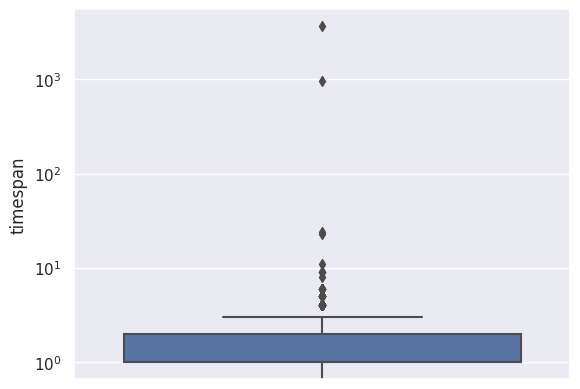

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


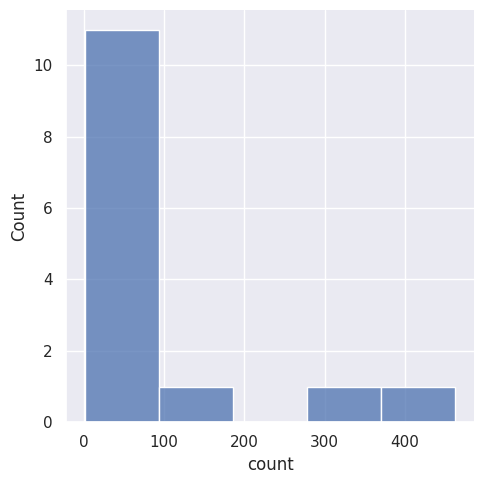

In [133]:
# Calculating days between publish and trending date
temporary = []
for data in all_dataframes:
    temp = data
    temp['timespan'] = (temp['trending_date'] - temp['publish_date']).dt.days
    temporary.append(temp)
# Plotting
to_trending = temporary[0].sample(1000).groupby('video_id').timespan.max() # CA
sns_ax = sns.boxplot(y = to_trending)
_ = sns_ax.set(yscale = "log")
plt.show()
_ = sns.displot(to_trending.value_counts(),bins='rice',kde=False)

## Observation

As we can see from both plots above, most videos take less a 100 days to reach the trending page. This can be attributed to viral natural of content on the internet, that if some online content is popular, it will often be shared and viewed within it’s short time span of relevancy.

Users like videos from which category more?
We also decided to check which category overall had the most likes from all the categories.

In [136]:
temp = combined_df
temp = temp.groupby('category')[['views', 'likes']].apply(lambda x: x.astype(int).sum())
temp = temp.sort_values(by='likes', ascending=False).head()
temp

,views,likes
category,,
Entertainment,17588684816,471875235
Music,18175188197,444810358
Comedy,4573395735,218752101
People & Blogs,5606737191,157767404
Howto & Style,2215631503,77250720


## Observation

As we can see, most liked category is ‘Entertainment’ for all countries. This shows user preference to use YouTube as an entertainment platform.

### Users comment on which category the most?
Similarly we decided to explore which category overall gets the most comments.

In [138]:
temp = combined_df
temp = temp.groupby('category')[['views','likes', 'comment_count']].apply(lambda x: x.astype(int).sum())
temp = temp.sort_values(by='comment_count', ascending=False).head()
temp

,views,likes,comment_count
category,,,
Entertainment,17588684816,471875235,68370734
Music,18175188197,444810358,36232011
People & Blogs,5606737191,157767404,24662974
Comedy,4573395735,218752101,23294928
News & Politics,3470582735,53466715,14956514


## Frequently occurring words in tags and description
Next, we decided to move onto the tags often attached to the video and video descriptions. Tags are often attached to videos to make them easier to search up and to include them into their relevant categories. Descriptions are written to by the up-loaders, often either giving a brief description of the video or adding relevant links. We decided to check whether there were any common words present in the tags and descriptions. For this purpose, we used a word cloud, where the most often appearing words appear the largest.

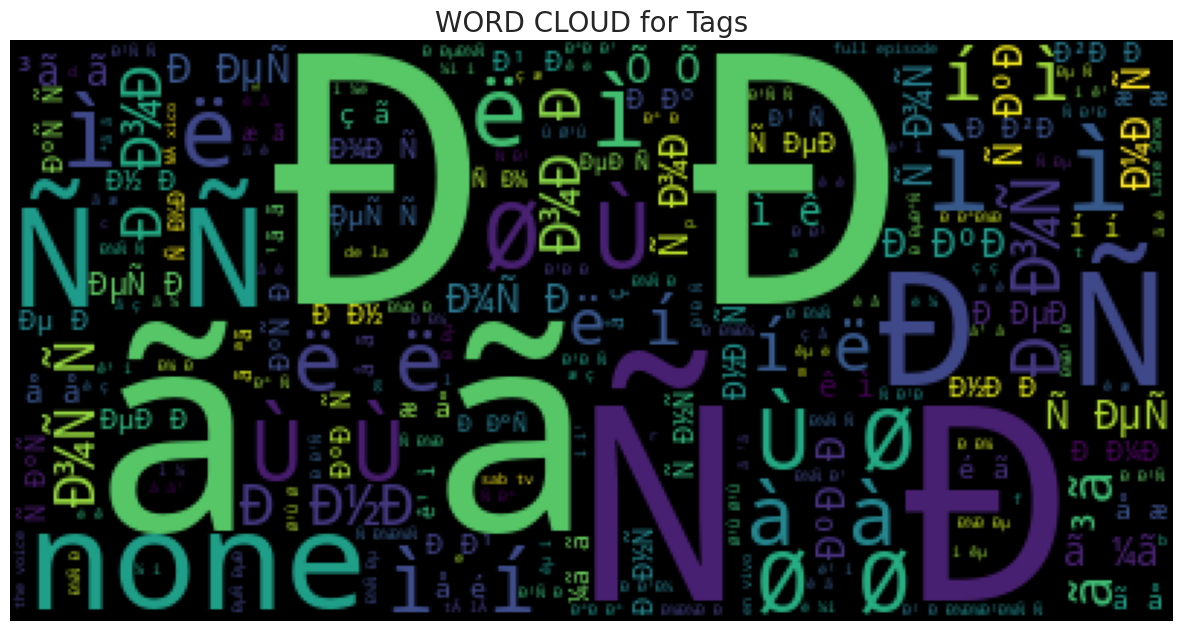

In [145]:
plt.figure(figsize = (15, 15))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
background_color = 'black',
stopwords = stopwords,
max_words = 1000,
max_font_size = 120,
random_state = 42
).generate(str(combined_df['tags']))

plt.imshow(wordcloud)
plt.title('WORD CLOUD for Tags', fontsize = 20)
plt.axis('off')
plt.show()

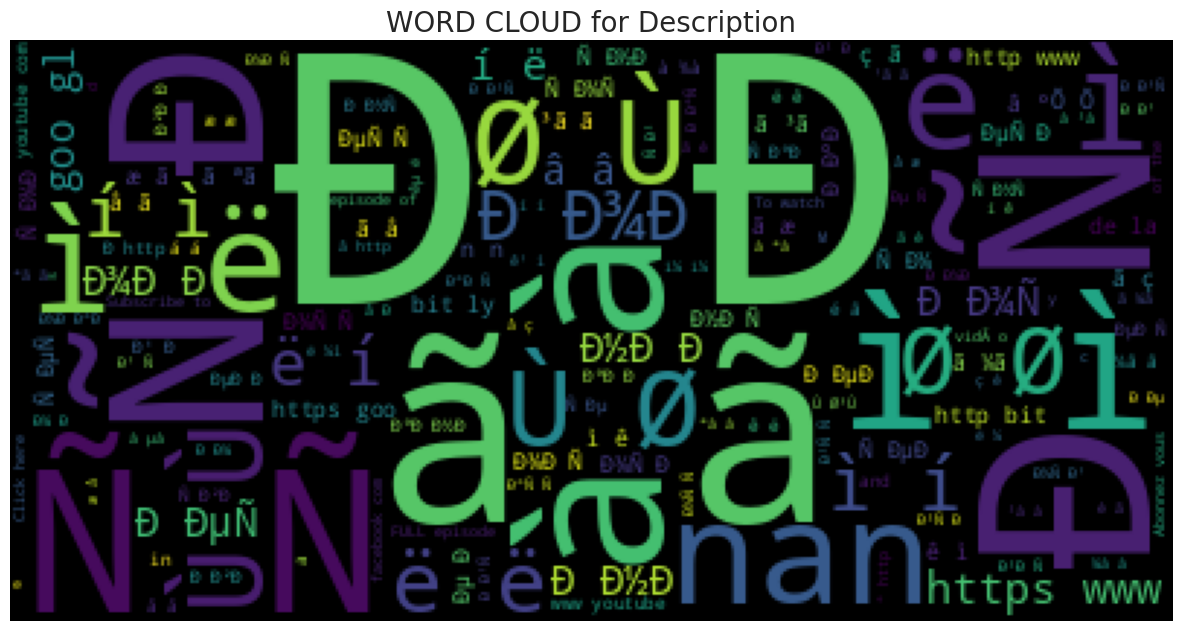

In [146]:
# For description
    
plt.figure(figsize = (15, 15))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
background_color = 'black',
stopwords = stopwords,
max_words = 1000,
max_font_size = 120,
random_state = 42
).generate(str(combined_df['description']))

plt.imshow(wordcloud)
plt.title('WORD CLOUD for Description', fontsize = 20)
plt.axis('off')
plt.show()

## Correlation between views, likes, dislikes, and comments
Next, we decided to see whether or there was any correlation between views, likes, dislikes, and comments.

In [147]:
col = ['views', 'likes', 'dislikes', 'comment_count']
corr = combined_df[col].corr()
corr

,views,likes,dislikes,comment_count
views,1.000000,0.768352,0.378172,0.423572
likes,0.768352,1.000000,0.435397,0.700513
dislikes,0.378172,0.435397,1.000000,0.667473
comment_count,0.423572,0.700513,0.667473,1.000000


## Observation

When evaluating the correlation between all the variables, the correlation of each feature with itself is also included, which is always 1, so that is why the graph always has the red diagonal from the upper left to the lower right.

We can see from the results, there is a positive relation between views and likes, likes and comment_count, dislikes and comment_count. We came to this conclusion as anytime the correlation coefficient, denoted as corr, is greater than zero, it’s a positive relationship.